In [2]:

##Import all necessary packages-------------------------------------------------------------
import math
import jupytext
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv 
from tabulate import tabulate

### .py Conversion for git

In [3]:
#read the current notebook file 
nb = jupytext.read("HW3Q2+3.ipynb")

#write the current notebook to the 'py:percent' format
jupytext.write(nb, "py-scripts/HW3Q2+3.py", fmt="py:percent")

### Kalman Filter Implementation
This focuses on the implementation of the Kalman Filter as the optimal linear filter for the system

$$
\begin{bmatrix}
\dot{x}\\
\dot{y}
\end{bmatrix}

= 
\begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix}

\begin{bmatrix}
x\\
y
\end{bmatrix}
$$



Text(0.5, 1.0, 'Kalman Filter Path')

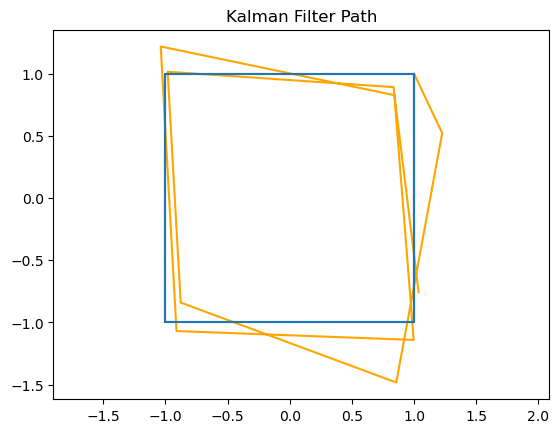

In [226]:
##Create our initial conditions-------------------------------------------------------------
#Initial state and timestep
x0          = np.array([  1,   1])
std         = math.sqrt(0.1)
std_scale   = np.sqrt(np.array([0.1, 0.1]))
dt = 0.1

#Normally distributed process and measurement both have a variance of 0.1
A = np.array([ [0,  1],
               [-1, 0]])

C = np.identity(2)

#Covariance matrices for the process and measurement noise. R and Q are able to change over time
Q       = np.diag([0.1 , 0.1])
R       = np.diag([0.1 , 0.1])
CoVar   = np.diag([0.1 , 0.1]) 

#Create the initial belief step using the initial condition as the center,
#with the specified process covariance matrix. 
Initial = np.random.default_rng().normal(loc=x0, scale=std_scale, size=(100, 2)).T

#Find the mean of the system. 
mu      = np.mean(Initial, axis=1).reshape(2,1)

#Kalman Path
path        = np.ndarray((2, 11))
CoVar_Arr   = np.ndarray((4,10))

path[:, 0] = x0

##Kalman Filter--------------------------------------------------------------------------
#Create the ground truth and intialize our array.
optimal = x0.reshape(2,1)
optimal_path = np.ndarray([2,10])

for i in range(10):
    #Update our optimal path plot.
    optimal_path[:,i] = optimal.flatten()

    ##Measurement Step
    #Create the measurement model that we are going to use. 
    z = C @ optimal + np.random.multivariate_normal(np.zeros(2), Q).reshape(2,1)

    ##Add to path and the covariance matrix
    CoVar_Arr[:, i ]    = CoVar.flatten()

    ##Prediction Step
    mu_bar      = A @ mu
    CoVar_bar   = A @ CoVar @ A.T + R 
    
    #Kalman Gain
    kt      = CoVar_bar @ C.T @ inv(C @ CoVar_bar @ C.T  + Q)
    mu      = mu_bar + kt @ (z.reshape(2,1) - C @ mu_bar)
    CoVar   = (np.identity(2) - kt @ C) @ CoVar_bar
    path[:, i+1]          = mu[:,0]

    #Update our true state
    optimal = A @ optimal


##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots()
#Plotting the intitial distribution
axs.plot(path[0,:], path[1, :], c='orange',label="Kalman")
axs.plot(optimal_path[0, :],optimal_path[1, :],label='Ground Truth')
axs.axis("equal")
axs.set_title("Kalman Filter Path")

In [227]:
#Print out the covariance matrix 
state = np.ndarray.tolist(path[0:10])
time = np.ndarray.tolist(np.linspace(0, 1, 10))

data = []
data = zip(state[0],state[1],time)

#Tabulate the data 
col_names = ["X", "Y", "Timestep"]
print(" "*8 + "State Evolution")
print(tabulate(data, headers=col_names))

        State Evolution
        X          Y    Timestep
---------  ---------  ----------
 1          1           0
 1.22585    0.52317     0.111111
 0.856233  -1.48259     0.222222
-0.877672  -0.839861    0.333333
-0.982795   1.01679     0.444444
 0.835663   0.892891    0.555556
 0.99634   -1.14051     0.666667
-0.911227  -1.06895     0.777778
-1.03827    1.21992     0.888889
 0.84178    0.828227    1


In [228]:
covdata= []
cA = np.ndarray.tolist(CoVar_Arr)
covdata = zip(cA[0], cA[1], cA[2], cA[3], time)
col_names = ("(0,0)", "(0,1)", "(1,0)", "(1,1)", "Time")
print(" "*15 + "Flattened Covariance Matrix")
print(tabulate(covdata, headers=col_names))

               Flattened Covariance Matrix
    (0,0)    (0,1)    (1,0)      (1,1)      Time
---------  -------  -------  ---------  --------
0.1              0        0  0.1        0
0.0666667        0        0  0.0666667  0.111111
0.0625           0        0  0.0625     0.222222
0.0619048        0        0  0.0619048  0.333333
0.0618182        0        0  0.0618182  0.444444
0.0618056        0        0  0.0618056  0.555556
0.0618037        0        0  0.0618037  0.666667
0.0618034        0        0  0.0618034  0.777778
0.0618034        0        0  0.0618034  0.888889
0.0618034        0        0  0.0618034  1


### Kalman Filter Error Analysis

Text(0.5, 1.0, 'Kalman Filter Path')

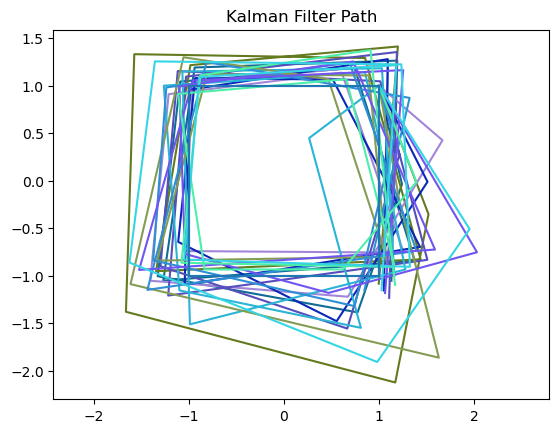

In [229]:
##Create our initial conditions-------------------------------------------------------------
#Initial state and timestep
x0          = np.array([  1,   1])
std         = math.sqrt(0.1)
std_scale   = np.sqrt(np.array([0.1, 0.1]))
dt = 0.1

#Normally distributed process and measurement both have a variance of 0.1
A = np.array([ [0,  1],
               [-1, 0]])

C = np.identity(2)

#Covariance matrices for the process and measurement noise. R and Q are able to change over time
Q       = np.diag([0.1 , 0.1])
R       = np.diag([0.1 , 0.1])
CoVar   = np.diag([0.1 , 0.1]) 

#Create an array of zeros where we can store the path of the particular Kalman Filter.
#Will be 3D so that each has it own accessible path in an array. Remember to assign the initial condition 
#to all of them
path_Arr = np.zeros((2,11,11))

for i in range(11): 
    path_Arr[:,0, i] = x0

#Create the local error array to archive the local error of each Kalman Filter.
local_err = np.zeros((2,11))
global_err= np.zeros((11,100))

#Iterate over 100 samples
for jj in range(0, 100):
    #Create the initial belief step using the initial condition as the center,
    #with the specified process covariance matrix. 
    Initial = np.random.default_rng().normal(loc=x0, scale=std_scale, size=(100, 2)).T

    #Find the mean of the system. 
    mu      = np.mean(Initial, axis=1).reshape(2,1)

    #Create and populate our mu array and our covariance array. There are 10 nearby and 1 optimal.
    mu_Arr = np.asanyarray([mu.flatten() for i in range(11)]).T
    CoVar_Arr = np.asanyarray([CoVar.flatten() for i in range(11)]).T

    #Empty arrays so that we can store our Kalman Filters
    mu_bar_Arr = np.empty_like(mu_Arr)
    CoVar_bar_Arr = np.empty_like(CoVar_Arr)
    kt_Arr = np.empty_like(CoVar_bar_Arr)

    ##Kalman Filter--------------------------------------------------------------------------
    #Create the ground truth and intialize our optimal array.
    optimal = x0.reshape(2,1)
    optimal_path = np.ndarray([2,10])

    for i in range(0, 10):
        #Update our optimal path plot.
        optimal_path[:,i] = optimal.flatten()

        ##Measurement Step
        #Create the measurement model that we are going to use. 
        #This will not change across the different Kalman filters.
        z = C @ optimal + np.random.multivariate_normal(np.zeros(2), Q).reshape(2,1)

        ##Loop over all over our potential Kalman Filters.
        for ii in range(0,11):
            
            ##Prediction Step
            mu_bar_Arr[:, ii]       = A @ mu_Arr[:, ii]
            CoVar_bar_Arr[:, ii]    = (A @ CoVar @ A.T + R).flatten()

            #Kalman Gain
            kt_Arr[:, ii]      = (CoVar_bar_Arr[:, ii].reshape(2,2) @ C.T @ inv(C @ CoVar_bar_Arr[:, ii].reshape(2,2) @ C.T  + Q)).flatten()

            #Add some noise to our Kalman Gain Filters
            for j in range(1, 11):
                kt_Arr[:, j] = kt_Arr[:, j] + np.random.multivariate_normal([0, 0, 0, 0], 0.1 * np.identity(4), size = 1)

            mu_Arr[:, ii]      = (mu_bar_Arr[:, ii, None] + kt_Arr[:, ii].reshape(2,2) @ (z.reshape(2,1) - C @ mu_bar_Arr[:, ii, None])).flatten()
            CoVar_Arr[:, ii]   = ((np.identity(2) - kt_Arr[:, ii].reshape(2,2) @ C) @ CoVar_bar_Arr[:, ii].reshape(2,2)).flatten()

            #Update the paths of our Kalman filters.
            path_Arr[:, i + 1, ii] = mu_Arr[:, ii]

            #Update the local error to reflect the difference in the states.
            # local_err[:, ii] = local_err[:, ii] + abs(np.divide((mu_Arr[:, ii, None] - optimal), optimal).flatten())
            local_err[:, ii] = 100 * abs(np.divide((mu_Arr[:, ii, None] - optimal), optimal).flatten())

    
        #Update our true state
        optimal = A @ optimal

        #Global error
        global_err[:, jj] = np.mean(local_err, axis=0)

        

##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots()
#Plotting the intitial distribution. We plot each optimal filter with a random color.
axs.plot(path_Arr[0,:, 0], path_Arr[1, :, 0], c=np.random.rand(1,3),label="Optimal")
axs.plot(path_Arr[0,:, 1], path_Arr[1, :, 1], c=np.random.rand(1,3),label="Kalman 2")
axs.plot(path_Arr[0,:, 2], path_Arr[1, :, 2], c=np.random.rand(1,3),label="Kalman 3")
axs.plot(path_Arr[0,:, 3], path_Arr[1, :, 3], c=np.random.rand(1,3),label="Kalman 4")
axs.plot(path_Arr[0,:, 4], path_Arr[1, :, 4], c=np.random.rand(1,3),label="Kalman 5")
axs.plot(path_Arr[0,:, 5], path_Arr[1, :, 5], c=np.random.rand(1,3),label="Kalman 6")
axs.plot(path_Arr[0,:, 6], path_Arr[1, :, 6], c=np.random.rand(1,3),label="Kalman 7")
axs.plot(path_Arr[0,:, 7], path_Arr[1, :, 7], c=np.random.rand(1,3),label="Kalman 8")
axs.plot(path_Arr[0,:, 8], path_Arr[1, :, 8], c=np.random.rand(1,3),label="Kalman 9")
axs.plot(path_Arr[0,:, 9], path_Arr[1, :, 9], c=np.random.rand(1,3),label="Kalman 10")
axs.plot(path_Arr[0,:, 10], path_Arr[1, :, 10], c=np.random.rand(1,3),label="Kalman 11")
axs.plot(optimal_path[0, :],optimal_path[1, :],label='Ground Truth')
axs.axis("equal")
axs.set_title("Kalman Filter Path")

In [243]:
#Find the average values of the error across both axes. 
error = np.ndarray.tolist(np.mean(global_err, axis=1))

#create the nested list
fil_data = []
for i in range(len(error)):
    if i ==0: 
        item = ["Optimal", error[i]]
        fil_data.append(item)
    else:
        item =["KF {}".format(i), error[i]]
        fil_data.append(item)

#Tabulate the data 
col_names = ["Filter", "Error (%)"]
print(tabulate(fil_data, headers=col_names))


Filter      Error (%)
--------  -----------
Optimal       17.8778
KF 1          21.0478
KF 2          23.3282
KF 3          22.9297
KF 4          23.9343
KF 5          23.2069
KF 6          25.8013
KF 7          24.1399
KF 8          23.3558
KF 9          21.7277
KF 10         23.5398


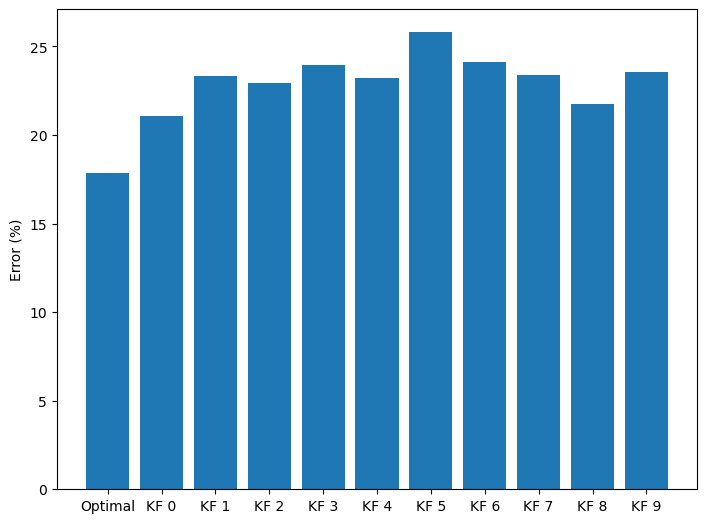

In [244]:
# creating the dataset
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lang = ["Optimal"] 
hmm = ["KF {}".format(i) for i in range(10)]
lang.extend(hmm)
students = [23,17,35,29,12]
ax.bar(lang,error)
ax.set_ylabel('Error (%)')
plt.show()

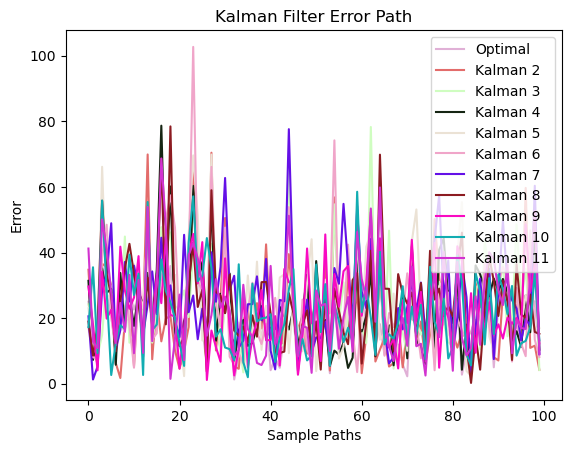

In [246]:
##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots()
#Plotting the intitial distribution
axs.plot(global_err[0,:], c=np.random.rand(1,3),label="Optimal")
axs.plot(global_err[1,:], c=np.random.rand(1,3),label="Kalman 2")
axs.plot(global_err[2,:], c=np.random.rand(1,3),label="Kalman 3")
axs.plot(global_err[3,:], c=np.random.rand(1,3),label="Kalman 4")
axs.plot(global_err[4,:], c=np.random.rand(1,3),label="Kalman 5")
axs.plot(global_err[5,:], c=np.random.rand(1,3),label="Kalman 6")
axs.plot(global_err[6,:], c=np.random.rand(1,3),label="Kalman 7")
axs.plot(global_err[7,:], c=np.random.rand(1,3),label="Kalman 8")
axs.plot(global_err[8,:], c=np.random.rand(1,3),label="Kalman 9")
axs.plot(global_err[9,:], c=np.random.rand(1,3),label="Kalman 10")
axs.plot(global_err[10, :], c=np.random.rand(1,3),label="Kalman 11")
axs.set_title("Kalman Filter Error Path")
axs.set_xlabel("Sample Paths")
axs.set_ylabel("Error")
axs.legend()